In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.stats import sem
from scipy import stats as st 
import math
import IPython
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import colorsys
import importlib
import svgutils
from svgutils.compose import *
import os.path
from scipy.stats import mannwhitneyu

In [2]:
#gene Colors
zfC = {
    'R'  : '#7d7d7d',
    'U' : '#B73AB9',
    'S' : '#4364F6',
    'M' : '#59CB3B',
    'L' : '#CE2A22',
}

zfG = {
    'wt' : '#000000',
    'tbx2a' : '#ab266b',
    'tbx2b' : '#421f8e',
    'foxq2' : '#001dd6',
}

zfGm = {
    'wt' : 'o',
    'tbx2a' : 'P',
    'tbx2b' : 'X',
    'foxq2' : '^',
}

prLabel = {
    'R'  : 'Rods',
    'U' : 'UV',
    'S' : 'S',
    'M' : 'M',
    'L' : 'L',
}


def formatFigure_General(plottitle, figH, axH, plotH):
    font_path = '/System/Library/Fonts/Avenir.ttc'
    fontTicks = font_manager.FontProperties(fname=font_path, size=18)
    fontLabels = font_manager.FontProperties(fname=font_path, size=22)
    fontTitle = font_manager.FontProperties(fname=font_path, size=28)

    axH.set_title(plottitle, fontproperties=fontTitle)
    axH.spines['top'].set_visible(False)
    axH.spines['right'].set_visible(False)
    
    axH.set_xlabel(axH.get_xlabel(), fontproperties=fontLabels)
    axH.set_ylabel(axH.get_ylabel(), fontproperties=fontLabels)

    for label in (axH.get_xticklabels() + axH.get_yticklabels()):
        label.set_fontproperties(fontTicks)
    return fontLabels

def formatFigure(figH, axH, plotH):
    fontLabels = formatFigureMain(figH, axH, plotH)
#     axH.set_xlabel('wt vs. cr', fontproperties=fontLabels)
    axH.set_ylabel('cells per 64 x 64 $\mu$m$^2$', fontproperties=fontLabels)
    axH.xaxis.set_tick_params(rotation=45)

def formatFigureRvU(figH, axH, plotH):
    fontLabels = formatFigureMain(figH, axH, plotH)
    axH.set_xlabel('Rods per 64 x 64 $\mu$m$^2$', fontproperties=fontLabels)
    axH.set_ylabel('UV cones per 64 x 64 $\mu$m$^2$', fontproperties=fontLabels)
    axH.xaxis.set_tick_params(rotation=45)
    
def formatFigureMvS(figH, axH, plotH):
    fontLabels = formatFigureMain(figH, axH, plotH)
    axH.set_xlabel('M cones per 64 x 64 $\mu$m$^2$', fontproperties=fontLabels)
    axH.set_ylabel('S cones per 64 x 64 $\mu$m$^2$', fontproperties=fontLabels)
    axH.xaxis.set_tick_params(rotation=45)

    
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import colorsys
    try:
        c = matplotlib.colors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*matplotlib.colors.to_rgb(c))
    return matplotlib.colors.rgb2hex(colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2]))

def estimateJitter(dataArray):
    """ creates random jitter scaled by local density of points"""
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(dataArray)
    density = kde(dataArray)
    jitter = np.random.randn(len(dataArray))*density
    return jitter

In [3]:
# dark background
plt.style.use('dark_background')
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
         "axes.linewidth" : 3,
         "xtick.major.width" : 3,
         "ytick.major.width" : 3,
         "xtick.major.size" : 8,
         "ytick.major.size" : 8,
         "text.color" : "w"}
plt.rcParams.update(params)
baseColor = '#ffffff' #white
font_prop = font_manager.FontProperties(fname='/System/Library/Fonts/Avenir.ttc')

In [3]:
# white background
plt.style.use('default')
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k",
         "axes.linewidth" : 3,
         "xtick.major.width" : 3,
         "ytick.major.width" : 3,
         "xtick.major.size" : 8,
         "ytick.major.size" : 8,
         "text.color" : "k"}
plt.rcParams.update(params)
baseColor = '#000000' #black
font_prop = font_manager.FontProperties(fname='/System/Library/Fonts/Avenir.ttc')

#### used to extract total reads from original files of Sun, 2018
```python
dPath = "/Users/angueyraaristjm/Documents/LiMolec/otherRNAseq/zfRods_Sun2018/GSE100062_RAW/"
fName = ["GSM2670720_GFPpos1_sn.count.txt",
         "GSM2670721_GFPpos2_sn.count.txt",
         "GSM2670722_GFPpos2_2_sn.count.txt",
         "GSM2670723_GFPpos5_2_sn.count.txt",
         "GSM2670724_GFPneg1_sn.count.txt",
         "GSM2670725_GFPneg2_sn.count.txt",
         "GSM2670726_GFPneg2_2_sn.count.txt",
         "GSM2670727_GFPneg5_2_sn.count.txt",
        ]
zfS = []
for f in fName:
    zfS1 = pd.read_csv(dPath + f, sep='\t', header=None)
    zfS = np.append(zfS,np.sum(zfS1[1]))
```

Mapped reads ranges from 97% to 97.4%, so taking this into account next

In [4]:
dPath = "/Users/angueyraaristjm/Documents/LiMolec/otherRNAseq/readCounts/"
fName = "zfPR_Angueyra2021nMappedReads.csv"
zfA = pd.read_csv(dPath + fName)
zfA = zfA['x'].values

dPath = "/Users/angueyraaristjm/Documents/LiMolec/otherRNAseq/readCounts/"
fName = "zfRet_Ogawa2021.csv"
zfO = pd.read_csv(dPath + fName)
zfO = zfO['x'].values

dPath = "/Users/angueyraaristjm/Documents/LiMolec/otherRNAseq/readCounts/"
fName = "zfRet_HoangBlackshaw2020.csv"
zfH = pd.read_csv(dPath + fName)
zfH = zfH['x'].values

dPath = "/Users/angueyraaristjm/Documents/LiMolec/otherRNAseq/readCounts/"
fName = "zfRods_Sun2018_totalReads.csv"
zfS = pd.read_csv(dPath + fName)
zfS = zfS['x'].values*.97


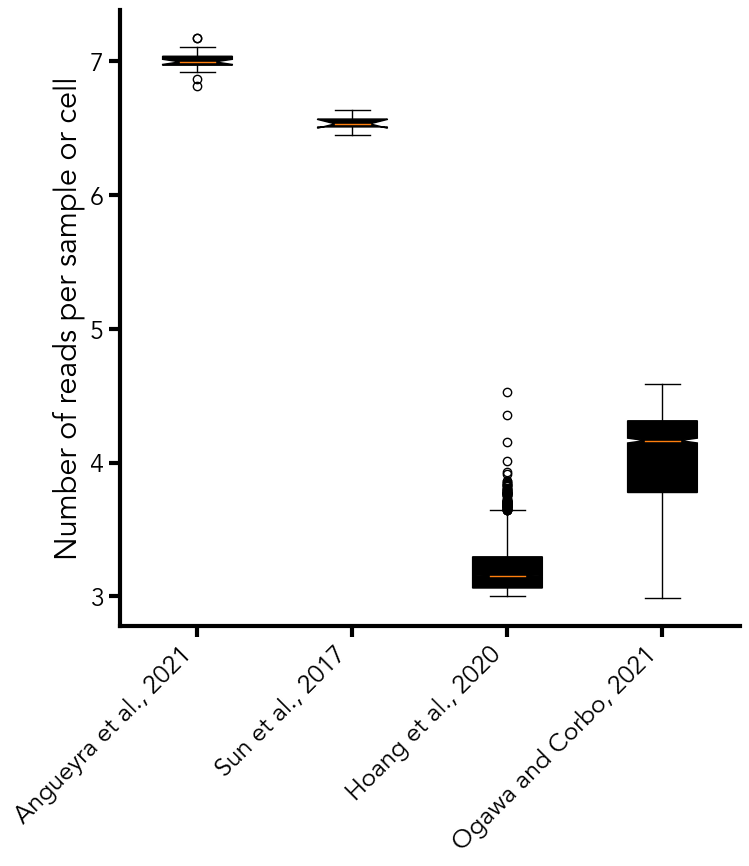

In [7]:
plotName = 'other_nReads'
fH, axH = plt.subplots(figsize= [8,8])


# nReads = [zfA, zfS, zfH, zfO]
nReads = [np.log10(zfA), np.log10(zfS), np.log10(zfH), np.log10(zfO)]

pH = axH.boxplot(nReads, patch_artist=True, meanline=False, showmeans=False, notch=True)

fontLabels = formatFigure_General('',fH, axH, pH)
# axH.ticklabel_format(style='plain')
axH.set_xticks([1,2,3,4]);
axH.set_xticklabels(['Angueyra et al., 2021','Sun et al., 2017', 'Hoang et al., 2020', 'Ogawa and Corbo, 2021'],rotation=45, ha='right')

# axH.set_yticks([0,4e6]);
# axH.set_yticklabels(['Angueyra et al., 2021','Sun et al., 2017', 'Hoang et al., 2020', 'Ogawa and Corbo, 2021'],rotation=45, ha='right')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

axH.set_ylabel('Number of reads per sample or cell', fontproperties=fontLabels)

colors = ['black', 'black', 'black', 'black']
 
for patch, color in zip(pH['boxes'], colors):
    patch.set_facecolor(color)
    

plt.savefig("/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/Manuscripts/2021_zfConeRNAseq/resources/{0}.svg".format(plotName), transparent=True, format="svg")
plt.show()

### Quantifying number of unique genes
> For Seurat objects, this is stored in seuratObj@meta.data$nFeature_RNA


 Angueyra, 2022:
	 non-zero expression detected in 18994/28440 of genes

 Sun, 2017:
	 non-zero expression detected in 13329/13329 of genes

 Hoang, 2021:
	 non-zero expression detected in 19242/24711 of genes

 Ogawa, 2022:
	 non-zero expression detected in 20952/22129 of genes


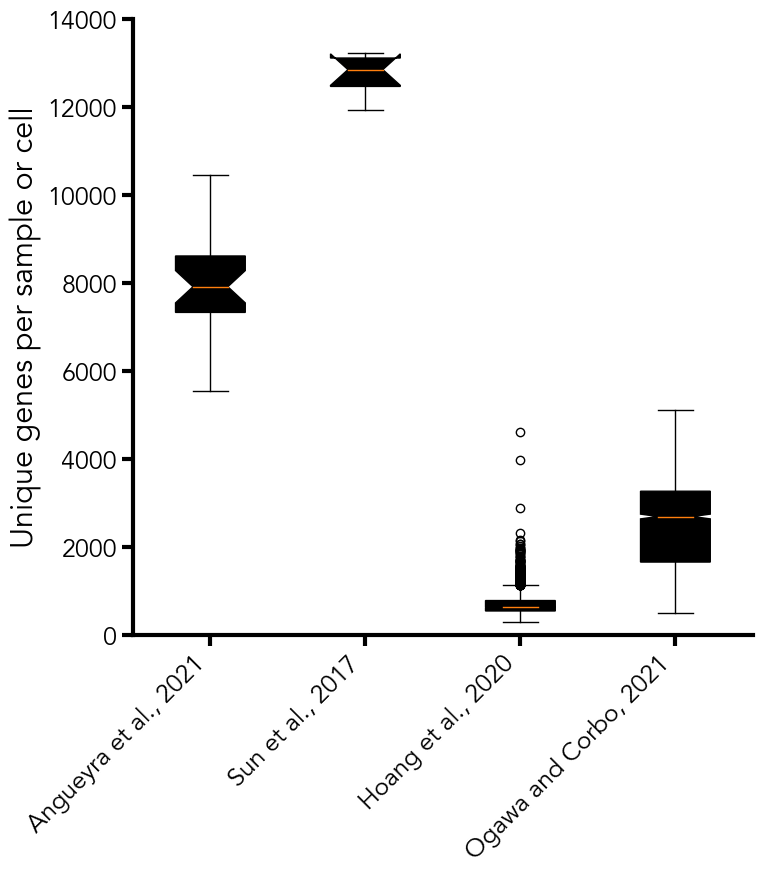

In [34]:
plotName = 'other_uniqueGenes'


gdf = pd.read_csv("~/Documents/eelMolec/zfRNAseq/20190827/20190827_DESeq2/00_rodsVcones/rodVCones_fpkm.csv") # get fpkm data
rdf = pd.read_csv("~/Documents/eelMolec/zfRNAseq/2018_Sun_facsRods/Sun2018_FACS_Rods.csv") # get fpkm data
hdf = pd.read_csv("~/Documents/eelMolec/zfRNAseq/2020_Hoang_zfRet10x/Hoang2020_10x_photoreceptors_oneM.csv") # get data
odf = pd.read_csv("~/Documents/eelMolec/zfRNAseq/2021_Ogawa_zfPR10x/Ogawa2021_10x_photoreceptors.csv") # get data

print("\n Angueyra, 2022:\n\t non-zero expression detected in {0}/{1} of genes".format(len(gdf[gdf['baseMean'].values>0]),len(gdf)))
print("\n Sun, 2017:\n\t non-zero expression detected in {0}/{1} of genes".format(len(rdf[rdf['baseMean'].values>0]),len(rdf)))
print("\n Hoang, 2021:\n\t non-zero expression detected in {0}/{1} of genes".format(len(hdf[hdf['pctMean'].values>0]),len(hdf)))
print("\n Ogawa, 2022:\n\t non-zero expression detected in {0}/{1} of genes".format(len(odf[odf['pctMean'].values>0]),len(odf)))

gdfU = []
for i in range(7,7+30):
    temp = gdf.iloc[:,i]
    gdfU = np.append(gdfU,(len(temp[temp>0])))
    
rdfU = []
for i in range(7,7+8):
    temp = rdf.iloc[:,i]
    rdfU = np.append(rdfU,(len(temp[temp>0])))


hdfU = pd.read_csv("~/Documents/eelMolec/zfRNAseq/2020_Hoang_zfRet10x/Hoang2020_photoAdult_nUniqueGenes.csv") # get data
hdfU = hdfU['x'].values

odfU = pd.read_csv("~/Documents/eelMolec/zfRNAseq/2021_Ogawa_zfPR10x/Ogawa2022_nUniqueGenes.csv") # get data
odfU = odfU['x'].values
    

fH, axH = plt.subplots(figsize= [8,8])

pH = plt.boxplot([gdfU,rdfU,hdfU,odfU],positions=[1,2,3,4], patch_artist=True, meanline=False, showmeans=False, notch=True)

# pH = plt.violinplot([gdfU,rdfU,hdfU,odfU],positions=[1,2,3,4],showmeans=False, showextrema=False, showmedians=True, quantiles=None, points=100)

# pHS = plt.scatter(np.random.normal(1, 0.02, size=len(gdfU)),gdfU, color = "#000000", alpha = 0.2)
# pHS = plt.scatter(np.random.normal(2, 0.02, size=len(rdfU)),rdfU, color = "#000000", alpha = 0.2)
# pHS = plt.scatter(np.random.normal(3, 0.04, size=len(hdfU)),hdfU, color = "#000000", alpha = 0.2)
# pHS = plt.scatter(np.random.normal(4, 0.04, size=len(odfU)),odfU, color = "#000000", alpha = 0.2)


fontLabels = formatFigure_General('',fH, axH, pH)
# axH.ticklabel_format(style='plain')
axH.set_xticks([1,2,3,4]);
axH.set_xticklabels(['Angueyra et al., 2021','Sun et al., 2017', 'Hoang et al., 2020', 'Ogawa and Corbo, 2021'],rotation=45, ha='right')


axH.set_ylabel('Unique genes per sample or cell', fontproperties=fontLabels)

colors = ['black', 'black', 'black', 'black']
 
for patch, color in zip(pH['boxes'], colors):
    # patch.set_alpha(0.2)
    patch.set_facecolor(color)
# axH.set_xticklabels(geneList * len(photoreceptors));
axH.set_ylim([0,14000]);

plt.savefig("/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/Manuscripts/2021_zfConeRNAseq/resources/{0}.svg".format(plotName), transparent=True, format="svg")
plt.show()

In [ ]:
# plotting relative values
plotName = 'rhoContamination'
fH, axH = plt.subplots(figsize= [8,8])

barW = 0.8; # bar width
barD = barW + .1;
# barP = -np.size(geneList)+1; # position in x-axis
barStep = 1; # distance between photoreceptor groups
barPos = []; #array to save bar positions

i = 0;
i = i+1;
pH = plt.bar([barStep*i], np.mean(angueyraC)/np.mean(angueyraR), width=barW, color='#000000');
i = i+1;
pH = plt.bar([barStep*i], np.mean(sunC)/np.mean(sunR), width=barW, color='#000000');
i = i+1;
pH = plt.bar([barStep*i], np.mean(hoangC)/np.mean(hoangR), width=barW, color='#000000');
i = i+1;
pH = plt.bar([barStep*i], np.mean(ogawaC)/np.mean(ogawaR), width=barW, color='#000000');

fontLabels = formatFigure_General('', fH, axH, pH)
    
axH.set_xticks([1,2,3,4]);
axH.set_xticklabels(['Angueyra et al., 2021','Sun et al., 2017', 'Hoang et al., 2020', 'Ogawa and Corbo, 2021'],rotation=45, ha='right')
axH.set_ylim([0,0.8]); # this was 400

axH.set_ylabel('Relative reads for $\itrho$\n in non-rod samples', fontproperties=fontLabels)

plt.savefig("/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/Manuscripts/2021_zfConeRNAseq/resources/{0}.svg".format(plotName), transparent=True, format="svg")
plt.show()